In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

from tqdm import trange

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

[Dataset Page](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29)  
[Download Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data)

In [3]:
brest_cancer_columns = [
    'id',
    'Clump Thickness',
    'Uniformity Cell Size', 
    'Uniformity Cell Shape', 
    'Marginal Adhesion', 
    'Single Epithelial Cell Size', 
    'Bare Nuclei', 
    'Bland Chromatin', 
    'Normal Nucleoli', 
    'Mitoses',
    'Class'
]
brest_cancer = pd.read_csv('../data/breast-cancer-wisconsin.data')
brest_cancer.columns = brest_cancer_columns
brest_cancer.drop('id', axis=1, inplace=True) # id do not play any role at classification

brest_cancer = brest_cancer[brest_cancer['Bare Nuclei'] != '?']  # TODO take care of it (replace with mean or smth else)
brest_cancer['Bare Nuclei'] = brest_cancer['Bare Nuclei'].astype('int')
brest_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 697
Data columns (total 10 columns):
Clump Thickness                682 non-null int64
Uniformity Cell Size           682 non-null int64
Uniformity Cell Shape          682 non-null int64
Marginal Adhesion              682 non-null int64
Single Epithelial Cell Size    682 non-null int64
Bare Nuclei                    682 non-null int64
Bland Chromatin                682 non-null int64
Normal Nucleoli                682 non-null int64
Mitoses                        682 non-null int64
Class                          682 non-null int64
dtypes: int64(10)
memory usage: 58.6 KB


In [3]:
brest_cancer.profile_report(style={'full_width':True})

## Feature Ranking

In [49]:
def make_features_ranking(x, y):
    n_features = x.shape[1]
    # f_classif: ANOVA test (F-value between label/feature for regression tasks)
    k_best_selector = SelectKBest(score_func=f_classif, k=n_features) 
    k_best_selector.fit(x, y)
    scores = k_best_selector.scores_ 
    column_scores = [ 
        {'name': name, 'score': round(score, 2)}  
        for name, score in zip(x.columns, scores)
    ]
    return sorted(column_scores, key=lambda x: x['score'], reverse=True)

In [5]:
x = brest_cancer.drop('Class', axis=1)
y = brest_cancer['Class']
features_ranking = make_features_ranking(x, y)
print('Features Ranking:')
for index, feature in enumerate(features_ranking, 1):
    print(f"{index}. {feature['name']} {feature['score']}")

Features Ranking:
1. Bare Nuclei 1422.73
2. Uniformity Cell Shape 1414.05
3. Uniformity Cell Size 1402.65
4. Bland Chromatin 920.35
5. Normal Nucleoli 725.66
6. Clump Thickness 712.48
7. Marginal Adhesion 676.13
8. Single Epithelial Cell Size 620.66
9. Mitoses 148.42


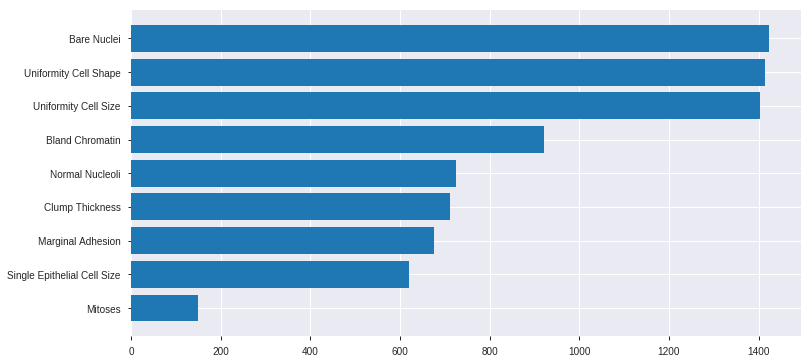

In [7]:
fscores = sorted([(f['name'], f['score']) for f in features_ranking], key=lambda x: x[1])
plt.figure(figsize=(12,6))
n_estimators = len(fscores)
plt.barh(range(n_estimators), [s[1] for s in fscores], align='center')
plt.yticks(range(n_estimators), [s[0] for s in fscores])
# plt.show()
plt.savefig('png/ranking.png')

### Experiment

#### Train Test Split

In [50]:
def make_train_test_split(data, target_column):
    x = data.drop(target_column, axis=1)
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    return dict(
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test
    ) 

In [51]:
def select_k_best(data, k):
    x = data['x_train']
    y = data['y_train']
    k_best_selector = SelectKBest(score_func=f_classif, k=k)   
    selected_data = {}
    selected_data['x_train'] = k_best_selector.fit_transform(x, y)
    selected_data['x_test'] = k_best_selector.transform(data['x_test'])
    return {**data, **selected_data}

In [53]:
CV_REPEAT_NUMBER = 10
CV_FOLDS = 3
SCORE_METHOD = 'accuracy'

In [ ]:
grid_search = GridSearchCV(
    param_grid=dict(
        hidden_layer_sizes=[(11,),(15,),(20,)],
        solver=['sgd', 'adam']  # 'adam' -> back propagation without momentum 
    ),
    estimator=MLPClassifier(),
    cv=StratifiedKFold(n_splits=CV_FOLDS)
)

features_scores = []
grid_search_params_scores = {}
learning_data = make_train_test_split(data=brest_cancer, target_column='Class')
features_numbers = learning_data['x_train'].shape[1]

for k in trange(1, features_numbers+1):
    k_features_score = []
    for _ in range(CV_REPEAT_NUMBER):
        selected_data = select_k_best(learning_data, k)
        grid_search.fit(selected_data['x_train'], selected_data['y_train'])
        grid_search_params_scores[k] = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']] 
        k_features_score.append(grid_search.score(selected_data['x_test'],selected_data['y_test']))
    features_scores.append(np.mean(k_features_score))

In [ ]:
from pprint import pprint
pprint(grid_search_params_scores)

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=pd.DataFrame(dict(
            k_features=list(range(1, features_numbers+1)), 
            scores=features_scores
    )), 
    x='k_features', 
    y='scores'
)

In [26]:
import itertools
import functools

def map_key_to_every_value(key, values):
    return [{key: value} for value in values]

def merge_dicts(dicts):
    return functools.reduce(lambda a, b: {**a, **b}, dicts) 

def product_from_dict(param_grid):
    kek = [map_key_to_every_value(key, value) for key, value in param_grid.items()]
    return [merge_dicts(args) for args in itertools.product(*kek)]

In [24]:
import json
from pandas import Series
from collections import OrderedDict

def select_data(x, y, k):
    k_best_selector = SelectKBest(score_func=f_classif, k=k)   
    return k_best_selector.fit_transform(x, y)


class SelectKBestGridSearch:
    def __init__(self, param_grid, estimator_cls, cv):
        self.param_grid = param_grid
        self.cv = cv
        self.estimator_cls = estimator_cls
        self.estimator = None
        self.result = {}
        
    def _cv_eval(self, x, y):
        if type(y) == Series:
            y = y.values
        scores = []
        for train_index, test_index in self.cv.split(x, y):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.estimator.fit(X_train, y_train)
            scores.append(self.estimator.score(X_test, y_test))
        return np.mean(scores)
    
    def _get_params_result(self, x, y):
        k_scores = OrderedDict() 
        n_features = x.shape[1]
        for k in trange(1, n_features+1):
            selected_x = select_data(x, y, k)
            score = self._cv_eval(selected_x, y)
            k_scores[k] = score
        return k_scores
    
    def fit(self, x, y):
        params_combinations = product_from_dict(self.param_grid)
        print(f'run {x.shape[1]} fits of {self.estimator_cls.__name__} for {len(params_combinations)} parametres')
        
        for params in product_from_dict(self.param_grid):
            self.estimator = self.estimator_cls(**params)
            params_key = json.dumps(params)  # convert dict to str because dict cant be a dict key
            self.result[params_key] = self._get_params_result(x, y)
            self.print_params_result(params_key)
            
    def print_params_result(self, params_key):
        print(params_key)
        for k, score in self.result[params_key].items():
            print('k:', k, 'score:', score)
            
    def get_result(self):
        return self.result   

In [27]:
from sklearn.model_selection import RepeatedStratifiedKFold
from pprint import pprint
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)
params_grid = dict(
        hidden_layer_sizes=[(11,),(15,),(20,)],
        solver=['sgd', 'adam']  # 'adam' -> back propagation without momentum 
)
N_REPEATS = 5
N_SPLITS=2
rskf_cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=N_REPEATS, random_state=42)
brest_cancer.dropna(inplace=True)
x = brest_cancer.drop('Class', axis=1)
y = brest_cancer['Class']
select_k_best_gs = SelectKBestGridSearch(
    param_grid=params_grid,
    cv=rskf_cv,
    estimator_cls=MLPClassifier
)
select_k_best_gs.fit(x, y)
gs_result = select_k_best_gs.get_result()

  0%|          | 0/9 [00:00<?, ?it/s]

run 9 fits of MLPClassifier for 6 parametres


  0%|          | 0/9 [00:00<?, ?it/s]

{"hidden_layer_sizes": [11], "solver": "sgd"}
k: 1 score: 0.9105417956656346
k: 2 score: 0.945732714138287
k: 3 score: 0.9542328861369109
k: 4 score: 0.9334571723426214
k: 5 score: 0.9398830409356724
k: 6 score: 0.9293120055039561
k: 7 score: 0.9281836945304438
k: 8 score: 0.9178998968008255
k: 9 score: 0.917015823873409


  0%|          | 0/9 [00:00<?, ?it/s]

{"hidden_layer_sizes": [11], "solver": "adam"}
k: 1 score: 0.9093584451324389
k: 2 score: 0.9504368765049879
k: 3 score: 0.9571792225662193
k: 4 score: 0.9410681114551082
k: 5 score: 0.9393034055727553
k: 6 score: 0.9343085655314758
k: 7 score: 0.9387323701410388
k: 8 score: 0.9346164430684553
k: 9 score: 0.9264310285517716


  0%|          | 0/9 [00:00<?, ?it/s]

{"hidden_layer_sizes": [15], "solver": "sgd"}
k: 1 score: 0.9090729274165806
k: 2 score: 0.9489542483660129
k: 3 score: 0.9566030271757825
k: 4 score: 0.9448864809081525
k: 5 score: 0.9422119023047817
k: 6 score: 0.9246336429308565
k: 7 score: 0.9240557275541794
k: 8 score: 0.9407602339181287
k: 9 score: 0.9337461300309597


  0%|          | 0/9 [00:00<?, ?it/s]

{"hidden_layer_sizes": [15], "solver": "adam"}
k: 1 score: 0.9087770897832816
k: 2 score: 0.9465978672170621
k: 3 score: 0.9524939800481598
k: 4 score: 0.9489834881320949
k: 5 score: 0.9474974200206399
k: 6 score: 0.948376332989336
k: 7 score: 0.9290041279669762
k: 8 score: 0.942516339869281
k: 9 score: 0.933144134846921


  0%|          | 0/9 [00:00<?, ?it/s]

{"hidden_layer_sizes": [20], "solver": "sgd"}
k: 1 score: 0.9120037839697283
k: 2 score: 0.9466064671482627
k: 3 score: 0.9533556931544547
k: 4 score: 0.9463312693498451
k: 5 score: 0.9413536291709667
k: 6 score: 0.9328224974200205
k: 7 score: 0.9343085655314758
k: 8 score: 0.923467492260062
k: 9 score: 0.9275662194702443


100%|██████████| 9/9 [00:13<00:00,  1.47s/it]

{"hidden_layer_sizes": [20], "solver": "adam"}
k: 1 score: 0.9081991744066047
k: 2 score: 0.951609907120743
k: 3 score: 0.9601186790505676
k: 4 score: 0.9545493636050912
k: 5 score: 0.9536670106639147
k: 6 score: 0.948672170622635
k: 7 score: 0.9366546267629859
k: 8 score: 0.9442948056415548
k: 9 score: 0.9366511867905055


In [39]:
def plot_params_result(result, title):
    ks = list(result.keys())
    scores = list(result.values())
    plt.figure(figsize=(12,6))
    sns.scatterplot(
        data=pd.DataFrame(dict(
                k_features=ks, 
                scores=scores
        )), 
        x='k_features', 
        y='scores'
    )
    plt.title(title)

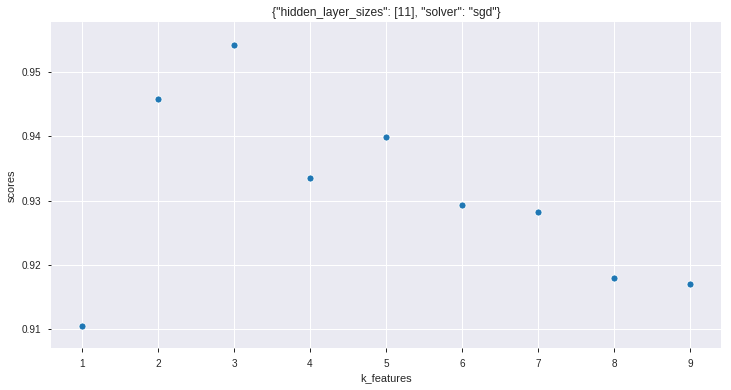

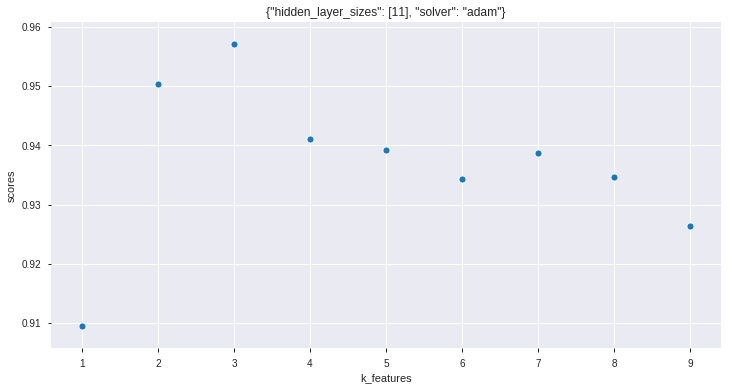

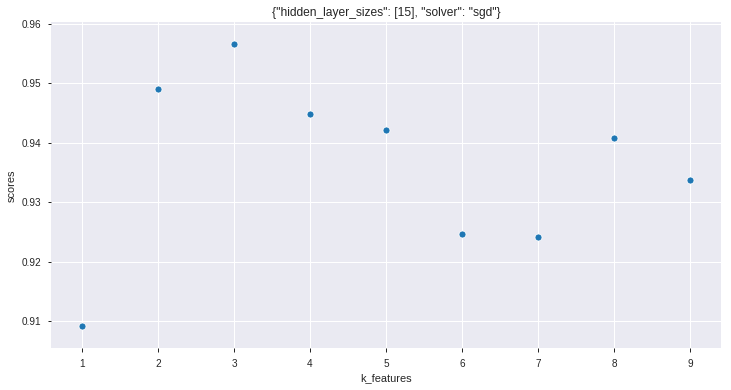

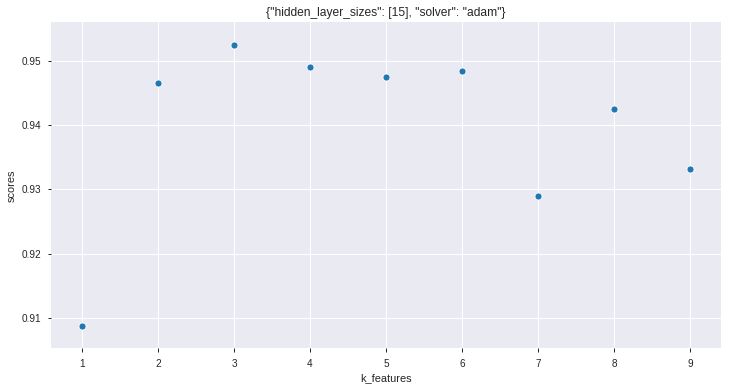

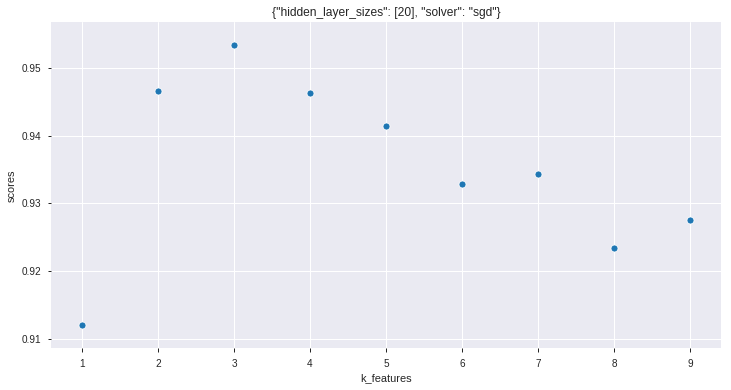

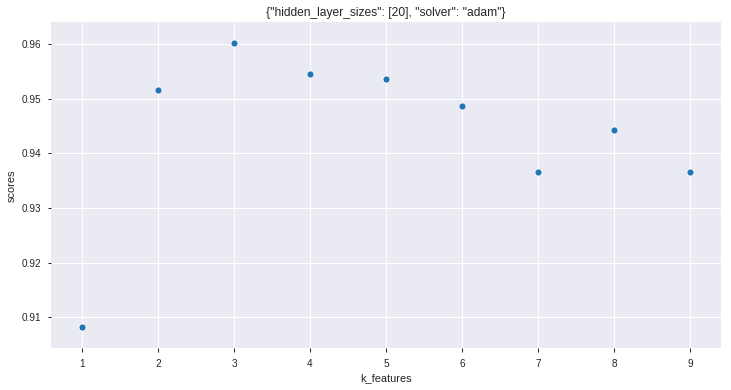

In [42]:
for params_key, result in gs_result.items():
    plot_params_result(result=result, title=params_key)

In [50]:
import json
def get_filename_from_mlp_params_key(params_key):
    params = json.loads(params_key)
    return f'hidden_layer_sizes_{params["hidden_layer_sizes"][0]}_solver_{params["solver"]}'

In [51]:
get_filename_from_mlp_params_key('{"hidden_layer_sizes": [20], "solver": "adam"}')

'hidden_layer_sizes_20_solver_adam'